## Model 1(a). Air-cooled generator with counter-current heat exchanger model 

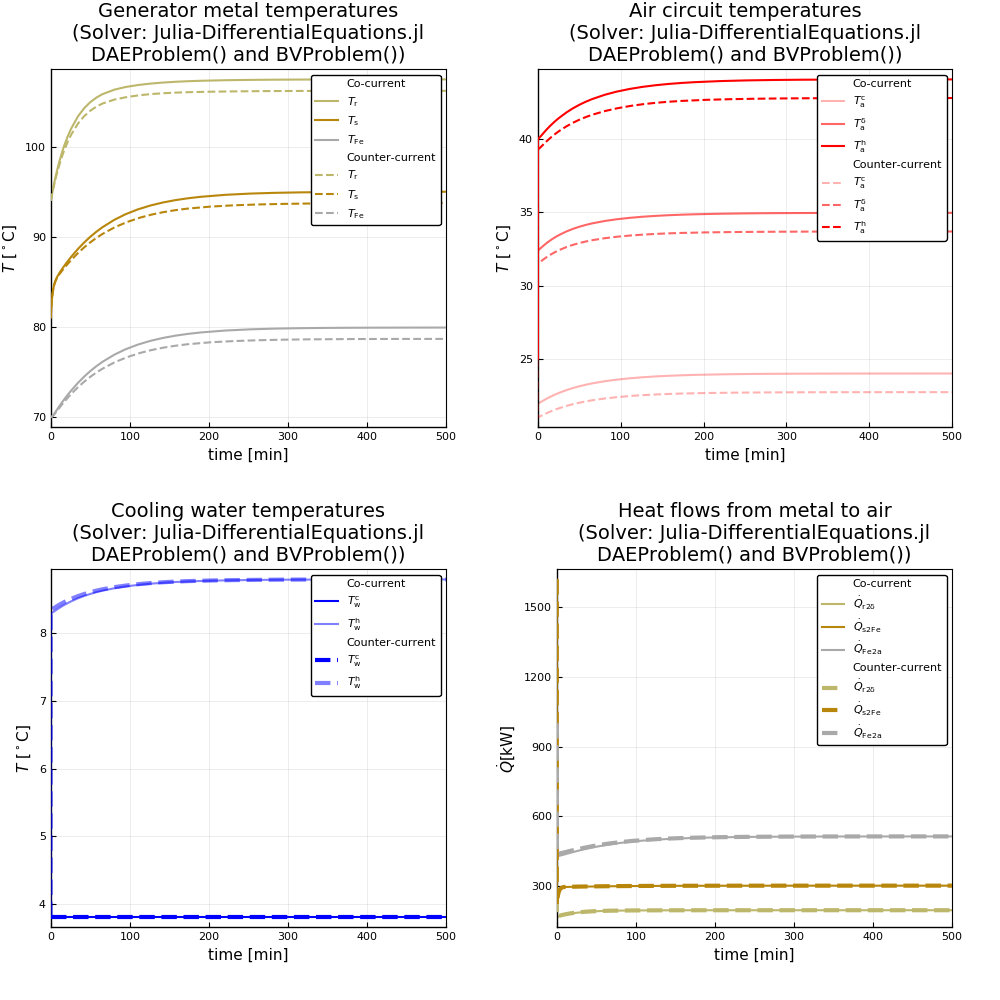

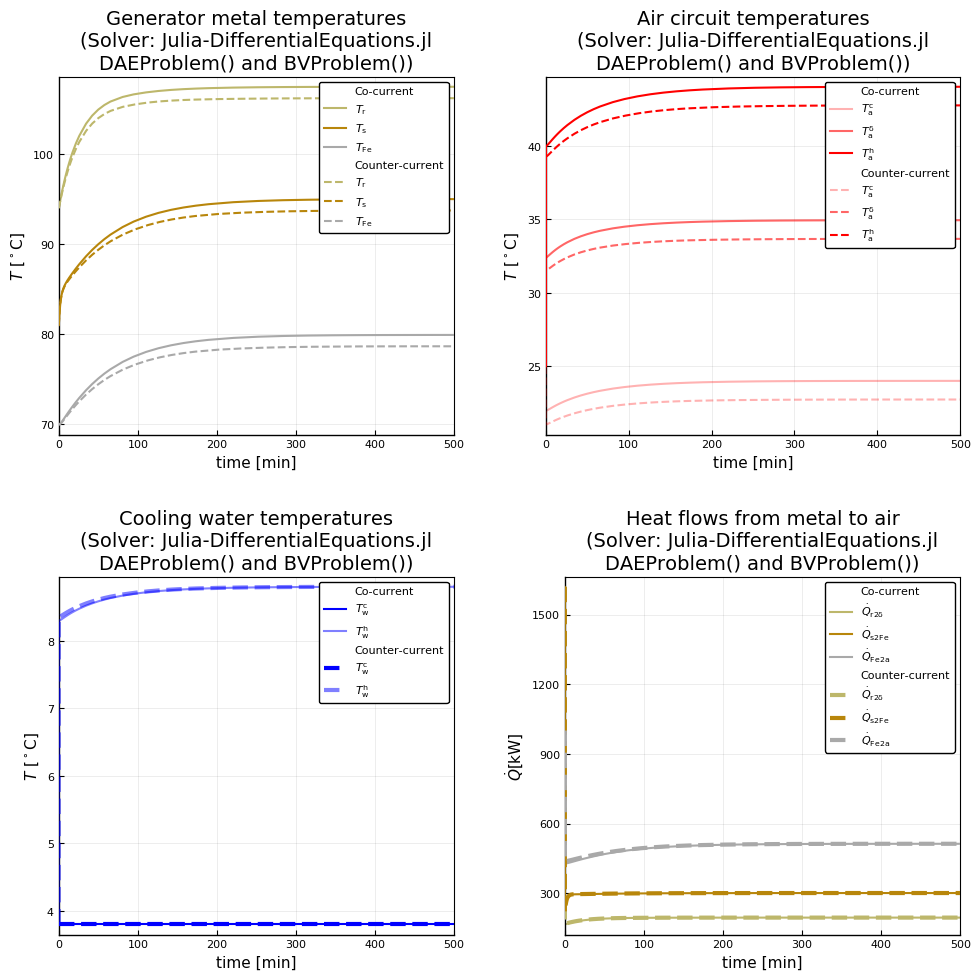

In [30]:
#Comparision of DAE with various plots
#    for Model1 and Model2-CounterCurrentAnalytical using OMJulia
#Filename:Comparision-DAE-Model1and2CounterCurrentAnalytical-various-plots.ipynb
#Author:  Madhusudhan Pandey, U
#Date: March 15, 2019
figpath = "C:/Users/pande/Desktop/Desktop/Thesis/ThesisLyx/figures/chapter3/";

using DifferentialEquations
using Sundials
using Plots
using Plots.PlotMeasures
# for more info see: https://docs.juliaplots.org/latest/attributes/
pyplot()
using LaTeXStrings;
# Linewidths and styles
LW1 = 1.5
LW2 = 2.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;

#Specifying Parameters
pa = 1.01e5 # " Atmospheric pressure , Pa "
#
chpa = 1.15 # " Specific heat capacity air , kJ.kg -1. K -1 # " 
chpw = 4.2 # " Specific heat capacity water , kJ.kg -1. K -1 # " 
chpCu = 0.385 # " Specific heat capacity copper , kJ.kg -1. K -1 # " 
chpFe = 0.465 # " Specific heat capacity iron , kJ.kg -1. K -1 # " 
#
mr = 9260. # " Mass of copper in rotor , kg # " 
ms = 6827. # " Mass of copper in stator , kg # " 
mFe = 71200. # " Mass of iron in stator , kg # " 
#
VhCu = 0.112e-3 # " Specific volume of copper , m3 / kg # " 
VhFe = 0.127e-3 # " Specific volume of iron , m3 / kg # " 
#
Vr = mr*VhCu # " Rotor copper volume , m3 # " 
Vs = ms*VhCu # " Stator copper volume , m3 # " 
VFe = mFe*VhFe # " Stator iron volume , m3 # " 
#
UAr2d = 2.7 # " Heat transfer , rotor copper to air gap , kW / K # " 
UAs2Fe = 20. # " Heat transfer , stator copper to stator iron , kW /K" 
UAFe2a = 14.3 # " Heat transfer , rotor iron to hot air , kW / K # " 
Up=0.88 # "Product of overall heat transfer and perimeter"
#
Hha_o = 0. # " Enthalpy of formation air , kJ / kg " 
HhCu_o = 0. # " Enthalpy of formation copper , kJ / kg # " 
HhFe_o = 0. # " Enthalpy of formation iron , kJ / kg # " 
#
Ta_o = 25. # " Standard state temperature air , C # " 
TCu_o = 25. # " Standard state temperature copper , C # " 
TFe_o = 25. # " Standard state temperature iron , C # " 
#
Rr = 0.16e-3 # " Ohmic resistance , rotor copper , kOhm, at 25 C # " 
Rs = 3.5e-6 # " Ohmic resistance , stator copper , kOhm, at 25 C"
#
# Two coefficient form
aCu = 2.559380892459937
bCu = 0.0011982506064166993
aFe = 0.19724545575725203
bFe = 0.00676358006431966
aa = 3.2822556593357177
ba = 0.0006721070788120142
aw = 3.6394816337401976
bw = 0.0012723320470041624
alphaCu = 0.00404
R = 8.314 # " J.K-1.mol-1 # "
MCu = 63.54 # " Molecular mass of Copper, g/mol"
MFe = 55.84 # "Molecular mass of Iron, g/mol"
Ma = 28.97 # "Molecular mass of Air, g/mol"
Mw = 18.01 # "Molecular mass of Water, g/mol"
#tuples of parameters
par_is = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,aCu,bCu,aFe,bFe,aa,ba,aw,bw,alphaCu,R,MCu,
    MFe,Ma,Mw];


#creating a model
function model1_co_and_counter_current_DAE(err,dxdt,x,par_is,t)
    #
    # Naming derivatives of differential variables
    dUrdt = dxdt[1]
    dUsdt = dxdt[2]
    dUFedt = dxdt[3]
    # Naming differential variables
    Ur = x[1]
    Us = x[2]
    UFe = x[3]
    # Naming algebraic variables
    Qdrs= x[4] # " Heat flow source in rotor copper , kW "
    Qdss = x[5] # " Heat flow source in stator copper , kW "
    Qdfs = x[6] # " Heat flow source due to friction loss , kW "
    Qdr2d = x[7] # " Heat flow from rotor copper to air gap , kW "
    Qds2Fe = x[8] # " Heat flow from stator copper to stator iron , kW "
    QdFe2a = x[9] # " Heat flow from stator iron to hot air , kW "
    #
    Hr = x[10] # " Enthalpy of rotor copper , kJ "
    Hs = x[11] # " Enthalpy of stator copper , kJ "
    HFe = x[12] # " Enthalpy of stator iron , kJ " 
    Hhr = x[13] # " Specific enthalpy of rotor copper , kJ / kg "
    Hhs = x[14] # " Specific enthalpy of stator copper , kJ / kg "
    HhFe = x[15] # " Specific enthalpy of stator iron , kJ / kg "
    #
    Hdac = x[16] # " Convective enthalpy of cold air , kW "
    Hdad = x[17] # " Convective enthalpy of air gap air , kW "
    Hdah = x[18] # " Convective enthalpy of hot air , kW " 
    Hhac = x[19] # " Specific enthalpy of cold air , kJ / kg "
    Hhad = x[20] # " Specific enthalpy of air gap air , kJ / kg "
    Hhah = x[21] # " Specific enthalpy of hot air , kJ / kg "
    #
    Twh = x[22] # " Hot water temperature , C " 
    Tac = x[23] # " Cold air temperature , C "
    Tad = x[24] # " Air gap air temperature , C "
    Tah = x[25] # " Hot air temperature , C "
    #
    Tr = x[26] # " Temperature of rotor copper , C " 
    Ts = x[27] # " Temperature of stator copper , C "
    TFe = x[28] # " Temperature of stator iron , C "
    
    pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,aCu,bCu,aFe,bFe,
    aa,ba,aw,bw,alphaCu,R,MCu,MFe,Ma,Mw = par_is
    
    # Computing inputs
    Twc = u_Twc(t)
    Ifd = u_Ifd(t)
    It = u_It(t)
    QdFes = u_QdFes(t)
    Wdf = u_Wdf(t)
    mdw = u_mdw(t)
    mda = u_mda(t)
    #
    # Equations
    #----------
    # - Algebraic equations
    err[1] = Hdac - Hdad + Qdr2d + Qdfs
    err[2] = Hdad - Hdah + QdFe2a
    
    err[3] = -Qdrs + 1.1* Rr * Ifd ^2
    err[4] = -Qdss + 3.0* Rs * It ^2
    err[5] = -Qdr2d + UAr2d *( Tr - Tad )
    err[6] = -Qds2Fe + UAs2Fe *( Ts - TFe )
    err[7] = -QdFe2a + UAFe2a *( TFe - Tah )
    err[8] = -Qdfs + 0.8* Wdf
    
    err[9] = -Hhr + HhCu_o + chpCu *( Tr - TCu_o )
    err[10] = -Hhs + HhCu_o + chpCu *( Ts - TCu_o )
    err[11] = -HhFe + HhFe_o + chpFe *( TFe - TFe_o )
    err[12] = -Hhac + Hha_o + chpa *( Tac - Ta_o )
    err[13] = -Hhad + Hha_o + chpa *( Tad - Ta_o )
    err[14] = -Hhah + Hha_o + chpa *( Tah - Ta_o )
    
    err[15] = -Hr+ mr * Hhr 
    err[16] = -Hs + ms * Hhs 
    err[17] = -HFe + mFe * HhFe
    
    err[18] = -Ur + Hr - pa * Vr
    err[19] = -Us + Hs - pa * Vs
    err[20] = -UFe + HFe - pa * VFe
    #
    err[21] = -Hdac + mda * Hhac 
    err[22] = -Hdad + mda * Hhad
    err[23] = -Hdah + mda * Hhah
    #
    #Solving boundary value for heat exchanger
    if heat_exchanger_type == "co-current"
        #length span of heat exchanger
        heat_exchanger_length=(0.0,50.0)
        
        function heat_exchanger_co_current!(dT,T,par_is,t)
            #Note that heatexchanger model of bernt lie and that of
            #project description x-direction is opposite so we neglect - sign in the formula here
            #T[1]=Ta, T[2]=Tw
            dT[1]=Up/(chpa*mda)*(T[2]-T[1])
            dT[2]=-Up/(chpw*mdw)*(T[2]-T[1])
        end
        ##initialGuess=[Tah,Twc]=for co-current
        ##initailGuess=[Tah,Twh]=for counter-current
        #initialGuess=[42.27,8.36]
        initial_guess=[Ta_o, u_Twc(0)]
        function bc_co_current!(residual,T,par_is,t)
            residual[1]=T[1][1]-Tah#Tah#Tah
            residual[2]=T[1][2]-Twc#Twc
        end

        bvp=BVProblem(heat_exchanger_co_current!,bc_co_current!,initial_guess,heat_exchanger_length,par_is)
        sol=solve(bvp, Shooting(Vern7()))
        #Tac,Twh=sol(50),sol(50) for co-current
        #Tac,Twh=sol(50),sol(0) for counter-current
        a,b=sol(50)
        c,d=sol(50)
        err[24]=-Tac+a
        err[25]=-Twh+d
        # counter current type
    elseif heat_exchanger_type == "counter-current"
            #length span of heat exchanger
        heat_exchanger_length=(0.0,50.0)
        
        function heat_exchanger_counter_current!(dT,T,par_is,t)
            #Note that heatexchanger model of bernt lie and that of
            #project description x-direction is opposite so we neglect - sign in the formula here
            #T[1]=Ta, T[2]=Tw
            dT[1]=Up/(chpa*mda)*(T[2]-T[1])
            dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
        end
        ##initialGuess=[Tah,Twc]=for co-current
        ##initailGuess=[Tah,Twh]=for counter-current
        #initialGuess=[42.27,8.36]
        initial_guess=[Ta_o, u_Twc(0)]
        function bc_counter_current!(residual,T,par_is,t)
            residual[1]=T[1][1]-Tah#Tah#Tah
            residual[2]=T[end][2]-Twc#Twc
        end

        bvp=BVProblem(heat_exchanger_counter_current!,bc_counter_current!,initial_guess,heat_exchanger_length,par_is)
        sol=solve(bvp, Shooting(Vern7()))
        #Tac,Twh=sol(50),sol(50) for co-current
        #Tac,Twh=sol(50),sol(0) for counter-current
        a,b=sol(50)
        c,d=sol(0)
        err[24]=-Tac+a
        err[25]=-Twh+d
    end
    
    # - differential equations
    err[26] = -dUrdt + Qdrs - Qdr2d
    err[27] = -dUsdt + Qdss - Qds2Fe
    err[28] = -dUFedt + QdFes + Qds2Fe - QdFe2a
    #
    return err
end
#
function u_Twc(t)
    return 3.8 # deg C
end
#
function u_Ifd(t)
    return 1055. # A
end
#
function u_It(t)
    return 5360. # A
end
#
function u_QdFes(t)
    return 212. # kW
end
#
function u_Wdf(t)
    return 528. # kW
end
#
function u_mdw(t)
    return 53.9 # kg/s
end
#
function u_mda(t)
    return 49.2 # kg/s
end

#Initial state parameters
Tr0 = 94.  #Initial temperature of rotor copper temperature , C 
Ts0 = 81.  #Initial temperature of stator copper temperature , C
TFe0 = 70.  #Initial temperature of stator iron temperature , C 
Hhr0 = HhCu_o + chpCu *( Tr0 - TCu_o )  #Initial rotor specific enthalpy , kJ / kg  
Hhs0 = HhCu_o + chpCu *( Ts0 - TCu_o )  #Initial stator copper specific enthalpy , kJ / kg  
HhFe0 = HhFe_o + chpFe *( TFe0 - TFe_o )  #Initial stator iron specific enthalpy , kJ / kg  
Hr0 = mr * Hhr0  #Initial rotor enthalpy , kJ  
Hs0 = ms * Hhs0  #Initial stator copper enthalpy , kJ  
HFe0 = mFe * HhFe0  #Initial stator iron enthalpy , kJ  
Ur0 = Hr0 - pa * Vr  #Initial rotor copper #internal energy , kJ  
Us0 = Hs0 - pa * Vs  #Initial stator copper #internal energy , kJ 
UFe0 = HFe0 - pa * VFe  #Initial stator iron #internal energy , kJ

#Initial values for algebriac variables
x0 = zeros(28,1)
x0[1] = Ur0
x0[2] = Us0
x0[3] = UFe0
x0[4] = 1.1* Rr * u_Ifd(0)^2
x0[5] = 3.0* Rs * u_It(0)^2
x0[6] = 0.8* u_Wdf(0)
x0[7] = UAr2d * Tr0
x0[8] = UAs2Fe * Ts0
x0[9] = UAFe2a * TFe0
x0[10] = Hr0 
x0[11] = Hs0
x0[12] = HFe0
x0[13] = Hhr0
x0[14] = Hhs0
x0[15] = HhFe0
x0[16] = u_mda(0) * x0[20]
x0[17] = u_mda(0) * x0[21]
x0[18] = u_mda(0) * x0[22]
x0[19] = Hha_o 
x0[20] = Hha_o 
x0[21] = Hha_o 
x0[22] = u_Twc(0)
x0[23] = Ta_o
x0[24] = Ta_o
x0[25] = Ta_o
x0[26] = Tr0
x0[27] = Ts0
x0[28] = TFe0
# Initial derivatives
dxdt0 = zeros(28,1)
dxdt0[1]= x0[4]-x0[7]
dxdt0[2]= x0[5]-x0[8]
dxdt0[3]= u_QdFes(0)+x0[8]-x0[9]
# Specifying differential variables
diff_vars = fill(false,28)
diff_vars[1],diff_vars[2],diff_vars[3]=true,true,true
# Time span
tspan = (0.0,500*60)
# Problem definition
# For co-current heat exchanger
heat_exchanger_type = "co-current"
prob_co_current = DAEProblem(model1_co_and_counter_current_DAE,dxdt0,x0,tspan,par_is,differential_vars=diff_vars)
sol_co_current = solve(prob_co_current,IDA());
# Metal temperatures
Tr_co_current = [sol_co_current.u[i][26] for i in 1:length(sol_co_current.u)]
Ts_co_current = [sol_co_current.u[i][27] for i in 1:length(sol_co_current.u)]
TFe_co_current = [sol_co_current.u[i][28] for i in 1:length(sol_co_current.u)]
# Air circuit temperatures
Tac_co_current = [sol_co_current.u[i][23] for i in 1:length(sol_co_current.u)]
Tad_co_current = [sol_co_current.u[i][24] for i in 1:length(sol_co_current.u)]
Tah_co_current = [sol_co_current.u[i][25] for i in 1:length(sol_co_current.u)]
# Cooling water temperatures
Twc_co_current = [u_Twc(sol_co_current.t[i]) for i in 1:length(sol_co_current.u)]
Twh_co_current = [sol_co_current.u[i][22] for i in 1:length(sol_co_current.u)]
t_co_current = [sol_co_current.t[i] for i in 1:length(sol_co_current.u)];
# Heat flows rate
Qdr2d_co_current = [sol_co_current.u[i][7] for i in 1:length(sol_co_current.u)]
Qds2Fe_co_current = [sol_co_current.u[i][8] for i in 1:length(sol_co_current.u)]
QdFe2a_co_current = [sol_co_current.u[i][9] for i in 1:length(sol_co_current.u)]


# For counter-current heat exchanger
heat_exchanger_type = "counter-current"
prob_counter_current = DAEProblem(model1_co_and_counter_current_DAE,dxdt0,x0,tspan,par_is,differential_vars=diff_vars)
sol_counter_current = solve(prob_co_current,IDA());
# Metal temperatures
Tr_counter_current = [sol_counter_current.u[i][26] for i in 1:length(sol_counter_current.u)]
Ts_counter_current = [sol_counter_current.u[i][27] for i in 1:length(sol_counter_current.u)]
TFe_counter_current = [sol_counter_current.u[i][28] for i in 1:length(sol_counter_current.u)]
# Air circuit temperatures
Tac_counter_current = [sol_counter_current.u[i][23] for i in 1:length(sol_counter_current.u)]
Tad_counter_current = [sol_counter_current.u[i][24] for i in 1:length(sol_counter_current.u)]
Tah_counter_current = [sol_counter_current.u[i][25] for i in 1:length(sol_counter_current.u)]
# Cooling water temperatures
Twc_counter_current = [u_Twc(sol_counter_current.t[i]) for i in 1:length(sol_counter_current.u)]
Twh_counter_current = [sol_counter_current.u[i][22] for i in 1:length(sol_counter_current.u)]
# Heat flows rate
Qdr2d_counter_current = [sol_counter_current.u[i][7] for i in 1:length(sol_counter_current.u)]
Qds2Fe_counter_current = [sol_counter_current.u[i][8] for i in 1:length(sol_counter_current.u)]
QdFe2a_counter_current = [sol_counter_current.u[i][9] for i in 1:length(sol_counter_current.u)]
t_counter_current = [sol_counter_current.t[i] for i in 1:length(sol_counter_current.u)];

# Plotting metal temperatures
# Separating legend for co-current
plot(1,1,label="Co-current",lc=:white)
plot!(t_co_current/60,Tr_co_current,lc=:darkkhaki ,lw=LW1,ls=LS1,label=L"$T_\mathrm{r}$")
plot!(t_co_current/60,Ts_co_current,lc=:darkgoldenrod ,lw=LW1,label=L"$T_\mathrm{s}$")
plot!(t_co_current/60,TFe_co_current,lc=:darkgrey ,lw=LW1,label=L"$T_\mathrm{Fe}$")
# Separating legend for counter-current
plot!(1,1,label="Counter-current",lc=:white)
plot!(t_counter_current/60,Tr_counter_current,lc=:darkkhaki ,lw=LW1,ls=LS4,label=L"$T_\mathrm{r}$")
plot!(t_counter_current/60,Ts_counter_current,lc=:darkgoldenrod ,lw=LW1,ls=LS4,label=L"$T_\mathrm{s}$")
plot!(t_counter_current/60,TFe_counter_current,lc=:darkgrey ,lw=LW1,ls=LS4,label=L"$T_\mathrm{Fe}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]" );
plot!(title="Generator metal temperatures\n(Solver: Julia-DifferentialEquations.jl\nDAEProblem() and BVProblem())",legend=:topright)
model1_metal_temp_DAEBVPJulia_solver=plot!(xlim=(0,500),reuse=false)

# Air circuit temperatures
# Separating legend for co-current
plot(1,1,label="Co-current",lc=:white)
plot!(t_co_current/60,Tac_co_current,lc=:red,la=0.3,lw=LW1,label=L"$T_\mathrm{a}^\mathrm{c}$")
plot!(t_co_current/60,Tad_co_current,lc=:red,la=0.6,lw=LW1,label=L"$T_\mathrm{a}^\mathrm{\delta}$")
plot!(t_co_current/60,Tah_co_current,lc=:red,la=1,lw=LW1,label=L"$T_\mathrm{a}^\mathrm{h}$")
# Separating legend for counter-current
plot!(1,1,label="Counter-current",lc=:white)
plot!(t_counter_current/60,Tac_counter_current,lc=:red,la=0.3,lw=LW1,ls=LS4,label=L"$T_\mathrm{a}^\mathrm{c}$")
plot!(t_counter_current/60,Tad_counter_current,lc=:red,la=0.6,lw=LW1,ls=LS4,label=L"$T_\mathrm{a}^\mathrm{\delta}$")
plot!(t_counter_current/60,Tah_counter_current,lc=:red,la=1,lw=LW1,ls=LS4,label=L"$T_\mathrm{a}^\mathrm{h}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")
plot!(title="Air circuit temperatures\n(Solver: Julia-DifferentialEquations.jl\nDAEProblem() and BVProblem())",legend=:topright)
model1_airckt_temp_DAEBVPJulia_solver=plot!(xlim=(0,500), reuse=false)
#

# Cooling water temperatures
# Separating legend for co-current
plot(1,1,label="Co-current",lc=:white)
plot!(t_co_current/60,Twc_co_current,lc=:blue,la=1,lw=LW1,label=L"$T_\mathrm{w}^\mathrm{c}$")
plot!(t_co_current/60,Twh_co_current,lc=:blue,la=0.5,lw=LW1,label=L"$T_\mathrm{w}^\mathrm{h}$")
# Separating legend for counter-current
plot!(1,1,label="Counter-current",lc=:white)
plot!(t_counter_current/60,Twc_counter_current,lc=:blue,la=1,lw=2*LW1,ls=LS4,label=L"$T_\mathrm{w}^\mathrm{c}$")
plot!(t_counter_current/60,Twh_counter_current,lc=:blue,la=0.5,lw=2*LW1,ls=LS4,label=L"$T_\mathrm{w}^\mathrm{h}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]")
plot!(title="Cooling water temperatures\n(Solver: Julia-DifferentialEquations.jl\nDAEProblem() and BVProblem())",legend=:topright)
model1_cooling_water_temp_DAEBVPJulia_solver=plot!(xlim=(0,500), reuse=false)


# Heat flows from metal to air 
# Separating legend for co-current
plot(1,1,label="Co-current",lc=:white)
plot!(t_co_current/60,Qdr2d_co_current,lc=:darkkhaki,lw=LW1,label=L"$\dot{Q}_\mathrm{r2\delta}$")
plot!(t_co_current/60,Qds2Fe_co_current,lc=:darkgoldenrod,lw=LW1,label=L"$\dot{Q}_\mathrm{s2Fe}$")
plot!(t_co_current/60,QdFe2a_co_current,lc=:darkgrey,lw=LW1,label=L"$\dot{Q}_\mathrm{Fe2a}$")
# Separating legend for counter-current
plot!(1,1,label="Counter-current",lc=:white)
plot!(t_counter_current/60,Qdr2d_counter_current,lc=:darkkhaki,lw=2*LW1,ls=LS4,label=L"$\dot{Q}_\mathrm{r2\delta}$")
plot!(t_counter_current/60,Qds2Fe_counter_current,lc=:darkgoldenrod,lw=2*LW1,ls=LS4,label=L"$\dot{Q}_\mathrm{s2Fe}$")
plot!(t_counter_current/60,QdFe2a_counter_current,lc=:darkgrey,lw=2*LW1,ls=LS4,label=L"$\dot{Q}_\mathrm{Fe2a}$")
plot!(xlabel="time [min]",ylabel=L"\dot{Q} \mathrm{[kW]}")
plot!(title="Heat flows from metal to air\n(Solver: Julia-DifferentialEquations.jl\nDAEProblem() and BVProblem())",legend=:topright)
model1_heat_flows_DAEBVPJulia_solver=plot!(xlim=(0,500), reuse=false)
#
display(plot(model1_metal_temp_DAEBVPJulia_solver,model1_airckt_temp_DAEBVPJulia_solver,
        model1_cooling_water_temp_DAEBVPJulia_solver,model1_heat_flows_DAEBVPJulia_solver,
        layout=grid(2,2),size = (1000, 1000),framestyle = :box,
        bottom_margin=10mm,right_margin=10mm))


In [8]:
if x=5
    print(1)
    else if 

UndefVarError: UndefVarError: plot_store not defined

## Model 1(b). Air-cooled generator with counter-current heat exchanger model

In [91]:
function genModel(err,dxdt,x,par,t)
    #
    # Naming derivatives of differential variables
    dUrdt = dxdt[1]
    dUsdt = dxdt[2]
    dUFedt = dxdt[3]
    # Naming differential variables
    Ur = x[1]
    Us = x[2]
    UFe = x[3]
    
    # Naming algebraic variables
    Qdrs= x[4]
    Qdss = x[5]
    Qdfs = x[6] # "Influent mass flow rate of S, g/s
    Qdr2d = x[7] # Effluent mass flow rate of S, g/s
    Qds2Fe = x[8] # Influent molar flow rate of A, mol/s
    QdFe2a = x[9] # Effluent molar flow rate of A, mol/s
    #A = x[10] # Molar rate of generation of A, mol/s
    #
    
    Hr = x[10] # Influent molar flow rate of B, mol/s
    Hs = x[11] # Effluent molar flow rate of B, mol/s
    HFe = x[12] # Molar rate of generation of B, mol/s
    Hhr = x[13] # "Influent enthalpy flow rate, J/min
    Hhs = x[14] # Effluent enthalpy flow rate, J/min
    HhFe = x[15] # Heat flow rate, J/min
    #
    Hdac = x[16] # Volume of pure S, L
    Hdad = x[17] # Volume of pure A, L
    Hdah = x[18] # Volume of pure B, L
    Hhac = x[19] # Mass of A, g
    Hhad = x[20] # Mass of B, g
    Hhah = x[21] # Effluent volumetric flow rate, L/min
    #
    
    #
    Twh = x[22] # Rate of reaction, mol/(L.s)
    Tac = x[23] # Reaction 'constant', ...
    Tad = x[24] # Absolute temperature, K
    Tah = x[25] # Reactor enthalpy, J
    #
    Tr = x[26] # Enthalpy of pure solvent, J
    Ts = x[27] # Enthalpy of pure A, J
    TFe = x[28] # Enthalpy of pure B, J
    
    # Naming parameters 
    pa = par[1]
    #
    chpa = par[2]
    chpw = par[3]
    chpCu = par[4]
    chpFe = par[5]
    #
    mr = par[6]
    ms = par[7]
    mFe = par[8]
    #
    VhCu = par[9]
    VhFe = par[10]
    #
    Vr = par[11]
    Vs = par[12]
    VFe = par[13]
    #
    UAr2d = par[14]
    UAs2Fe = par[15]
    UAFe2a = par[16]
    hAax = par[17]
    hAwx = par[18]
    UAx = par[19]
    Hha_o = par[20]
    HhCu_o = par[21]
    HhFe_o = par[22]
    Ta_o = par[23]
    TCu_o = par[24]
    TFe_o = par[25]
    Rr = par[26]
    Rs = par[27]
    #
    # Computing inputs
    Twc = u_Twc(t)
    Ifd = u_Ifd(t)
    It = u_It(t)
    QdFes = u_QdFes(t)
    Wdf = u_Wdf(t)
    mdw = u_mdw(t)
    mda = u_mda(t)
    #
    # Equations
    #----------
    # - Algebraic equations
    err[1] = Hdac - Hdad + Qdr2d + Qdfs
    err[2] = Hdad - Hdah + QdFe2a
    
    err[3] = -Qdrs + 1.1* Rr * Ifd ^2
    err[4] = -Qdss + 3.0* Rs * It ^2
    err[5] = -Qdr2d + UAr2d *( Tr - Tad )
    err[6] = -Qds2Fe + UAs2Fe *( Ts - TFe )
    err[7] = -QdFe2a + UAFe2a *( TFe - Tah )
    err[8] = -Qdfs + 0.8* Wdf
    
    err[9] = -Hhr + HhCu_o + chpCu *( Tr - TCu_o )
    err[10] = -Hhs + HhCu_o + chpCu *( Ts - TCu_o )
    err[11] = -HhFe + HhFe_o + chpFe *( TFe - TFe_o )
    err[12] = -Hhac + Hha_o + chpa *( Tac - Ta_o )
    err[13] = -Hhad + Hha_o + chpa *( Tad - Ta_o )
    err[14] = -Hhah + Hha_o + chpa *( Tah - Ta_o )
    
    err[15] = -Hr+ mr * Hhr 
    err[16] = -Hs + ms * Hhs 
    err[17] = -HFe + mFe * HhFe
    
    err[18] = -Ur + Hr - pa * Vr
    err[19] = -Us + Hs - pa * Vs
    err[20] = -UFe + HFe - pa * VFe
    #
    err[21] = -Hdac + mda * Hhac # Converting V in L to m3
    err[22] = -Hdad + mda * Hhad
    err[23] = -Hdah + mda * Hhah
    
    
    #parameters for BVProblem
    #p=[UP,mda,mdw,aa,ba,aw,bw,chpa,chpw]
    p=[0.88,49.2,53.9,3.42,1.21e-04,3.86,4.01e-04,1.15,4.2]
    #length span of heat exchanger
    xspan=(0.0,50.)
    function heatExchanger!(dT,T,p,t)
        #Note that heatexchanger model of bernt lie and that of
        #project description x-direction is opposite so we neglect - sign in the formula here
    
        dT[1]=Up/(chpa*mda)*(T[2]-T[1])
        dT[2]=-Up/(chpw*mdw)*(T[2]-T[1])
    end

    ##initialGuess=[Tah,Twh]
    initialGuess=[42.27,3.8]
    function bc!(residual,T,p,t)
        residual[1]=T[1][1]-Tah#Tah#Tah
        residual[2]=T[1][2]-Twc#Twc
    end

    bvp=BVProblem(heatExchanger!,bc!,initialGuess,xspan,p)
    sol=solve(bvp, Shooting(Vern7()))
    print(plot!())
    a,b=sol(50)
    c,d=sol(0)
    err[24]=-Tac+a
    err[25]=-Twh+d
    
    # - differential equations
    err[26] = -dUrdt + Qdrs - Qdr2d
    err[27] = -dUsdt + Qdss - Qds2Fe
    err[28] = -dUFedt + QdFes + Qds2Fe - QdFe2a
    #
    return err
end
#
function u_Twc(t)
    return 3.8 # deg C
end
#
function u_Ifd(t)
    return 1055. # A
end
#
function u_It(t)
    return 5360. # A
end
#
function u_QdFes(t)
    return 212. # kW
end
#
function u_Wdf(t)
    return 528. # kW
end
#
function u_mdw(t)
    return 53.9 # kg/s
end
#
function u_mda(t)
    return 49.2 # kg/s
end

u_mda (generic function with 1 method)

In [92]:
#Initial state parameters
Tr0 = 94.  #Initial temperature of rotor copper temperature , C 
Ts0 = 81.  #Initial temperature of stator copper temperature , C
TFe0 = 70.  #Initial temperature of stator iron temperature , C 
Hhr0 = HhCu_o + chpCu *( Tr0 - TCu_o )  #Initial rotor specific enthalpy , kJ / kg  
Hhs0 = HhCu_o + chpCu *( Ts0 - TCu_o )  #Initial stator copper specific enthalpy , kJ / kg  
HhFe0 = HhFe_o + chpFe *( TFe0 - TFe_o )  #Initial stator iron specific enthalpy , kJ / kg  
Hr0 = mr * Hhr0  #Initial rotor enthalpy , kJ  
Hs0 = ms * Hhs0  #Initial stator copper enthalpy , kJ  
HFe0 = mFe * HhFe0  #Initial stator iron enthalpy , kJ  
Ur0 = Hr0 - pa * Vr  #Initial rotor copper #internal energy , kJ  
Us0 = Hs0 - pa * Vs  #Initial stator copper #internal energy , kJ 
UFe0 = HFe0 - pa * VFe  #Initial stator iron #internal energy , kJ

#Initial values for algebriac variables
x0 = zeros(28,1)
x0[1] = Ur0
x0[2] = Us0
x0[3] = UFe0
x0[4] = 1.1* Rr * u_Ifd(0) ^2
x0[5] = 3.0* Rs * u_It(0) ^2
x0[6] = 0.8* u_Wdf(0)
x0[7] = UAr2d * (Tr0-31.31) #Tad0
x0[8] = UAs2Fe *(Ts0 - TFe0)
x0[9] = UAFe2a * (TFe0-39.12)
#x0[10] = -1033.34
x0[10] = Hr0 
x0[11] = Hs0
x0[12] = HFe0
x0[13] = Hhr0
x0[14] = Hhs0
x0[15] = HhFe0
x0[16] = u_mda(0) * x0[20]
x0[17] = u_mda(0) * x0[21]
x0[18] = u_mda(0) * x0[22]
x0[19] = Hha_o + chpa *( 20.8 - Ta_o ) #Tac0 from openmodelica
x0[20] = Hha_o + chpa *( 31.31 - Ta_o ) #Tad0
x0[21] = Hha_o + chpa *( 39.12 - Ta_o ) #Tah0
x0[22] = 8.36
x0[23] = 20.8
x0[24] = 31.31
x0[25] = 39.12
x0[26] = Tr0
x0[27] = Ts0
x0[28] = TFe0
# Initial derivatives
dxdt0 = zeros(28,1)
dxdt0[1]=26.64
dxdt0[2]=80.
dxdt0[3]=-10.


-10.0

In [93]:
using DifferentialEquations
# Specifying differential variables
diff_vars = fill(false,28)
diff_vars[1],diff_vars[2],diff_vars[3]=true,true,true
# Time span
tspan = (0.0,18000)
# Problem definition
probis = DAEProblem(genModel,dxdt0,x0,tspan,par_is,differential_vars=diff_vars)

using Sundials
solis = solve(probis,IDA());
Tr_co_cu = [solis.u[i][26] for i in 1:length(solis.u)]
Ts_co_cu = [solis.u[i][27] for i in 1:length(solis.u)]
TFe_co_cu = [solis.u[i][28] for i in 1:length(solis.u)]
t = [solis.t[i] for i in 1:length(solis.u)];

# Plotting counter-current and co-current heat exchanger model for Model-1

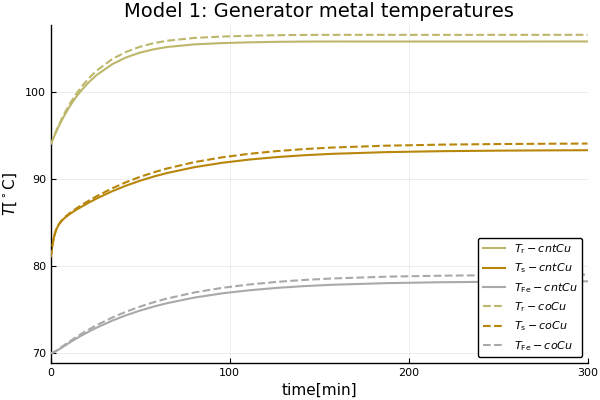

In [96]:

using Plots
#using PyPlot
pyplot()
using LaTeXStrings;
# Linewidths and styles
LW1 = 1.5
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;
plot(t/60,Tr_cnt_cu,lc=:darkkhaki ,lw=LW1,ls=LS1,label=L"$T_\mathrm{r}-cntCu$")
plot!(t/60,Ts_cnt_cu,lc=:darkgoldenrod ,lw=LW1,label=L"$T_\mathrm{s}-cntCu$")
plot!(t/60,TFe_cnt_cu,lc=:darkgrey ,lw=LW1,label=L"$T_\mathrm{Fe}-cntCu$")
plot!(t/60,Tr_co_cu,lc=:darkkhaki ,lw=LW1,ls=LS4,label=L"$T_\mathrm{r}-coCu$")
plot!(t/60,Ts_co_cu,lc=:darkgoldenrod ,lw=LW1,ls=LS4,label=L"$T_\mathrm{s}-coCu$")
plot!(t/60,TFe_co_cu,lc=:darkgrey ,lw=LW1,ls=LS4,label=L"$T_\mathrm{Fe}-coCu$")
plot!(xlabel="time[min]",ylabel=L"$T$[${}^\circ$C]" )
plot!(title="Model 1: Generator metal temperatures")
plot!(xlim=(0,300))


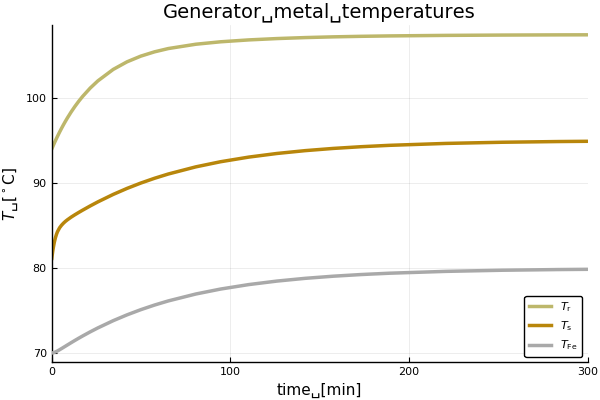

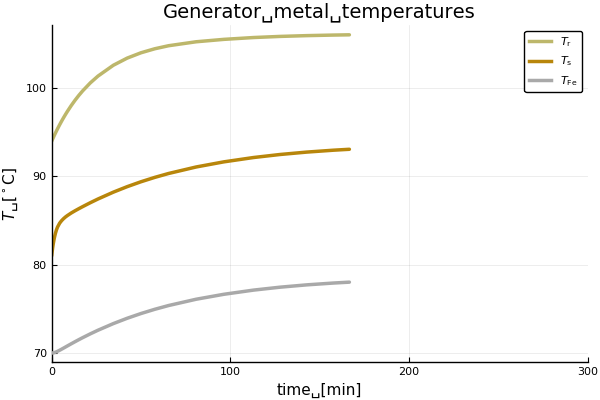

In [28]:
LW1 = 2.5
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;
plot(t/60,Tr,lc=:darkkhaki ,lw=LW1,label=L"$T_\mathrm{r}$")
plot!(t/60,Ts,lc=:darkgoldenrod ,lw=LW1,label=L"$T_\mathrm{s}$")
plot!(t/60,TFe,lc=:darkgrey ,lw=LW1,label=L"$T_\mathrm{Fe}$")
plot!(xlabel="time␣[min]",ylabel=L"$T$␣[${}^\circ$C]" )
plot!(title="Generator␣metal␣temperatures")
plot!(xlim=(0,300))

In [ ]:
# Naming parameters 
    pa = par[1]
    #
    chpa = par[2]
    chpw = par[3]
    chpCu = par[4]
    chpFe = par[5]
    #
    mr = par[6]
    ms = par[7]
    mFe = par[8]
    #
    VhCu = par[9]
    VhFe = par[10]
    #
    Vr = par[11]
    Vs = par[12]
    VFe = par[13]
    #
    UAr2d = par[14]
    UAs2Fe = par[15]
    UAFe2a = par[16]
    hAax = par[17]
    hAwx = par[18]
    UAx = par[19]
    Hha_o = par[20]
    HhCu_o = par[21]
    HhFe_o = par[22]
    Ta_o = par[23]
    TCu_o = par[24]
    TFe_o = par[25]
    Rr = par[26]
    Rs = par[27]
    #
    # Computing inputs
    Twc = u_Twc(t)
    Ifd = u_Ifd(t)
    It = u_It(t)
    QdFes = u_QdFes(t)
    Wdf = u_Wdf(t)
    mdw = u_mdw(t)
    mda = u_mda(t)
    #

In [19]:
function f(out,du,u,p,t)
  a,b,c=u  
  out[1] = - 0.04a              + 1e4*b*c - da
  out[2] = + 0.04a - 3e7*b^2 - 1e4*b*c - db
  out[3] = a + b + c - 1.0
end

u₀ = [1.0, 0, 0]
du₀ = [-0.04, 0.04, 0.0]
tspan = (0.0,100000.0)

using DifferentialEquations
differential_vars = [true,true,false]
prob = DAEProblem(f,du₀,u₀,tspan,differential_vars=differential_vars)
using Sundials
sol = solve(prob,IDA())
using Plots; plotly() # Using the Plotly backend
plot(sol, xscale=:log10, tspan=(1e-6, 1e5), layout=(3,1))

UndefVarError: UndefVarError: d not defined